# All Mart - High Value Customer Identification

Identificação de clientes mais valiosos de uma empresa e projecção de um programa de fidelidade para os mesmos.

# Planejamento da Solução (IOT)

## Input - Entrada

1. Problema de Negócio
    - Selecionar os clientes mais valiosos para integrar um programa de Fidelização
2. Conjunto de dados
     - Vendas de um e-commerce online, durante o período de um ano.

## Output - Saída

1. A indicação das pessoas que farão parte do programa de _insiders_
    - Lista: cliente_id | is_insider | 
    

2. Relatório com as respostas das perguntas de negócio:
    - Quem são as pessoas elegíveis para participar do programa insiders?
    - Quantos clientes farõa parte do grupo?
    - Quais as principais características desses clientes?
    - Qual a porcentagem de contribuição do faturamento, vinda do programa?
    - Qual a expectativa de faturamento (LTV) desse grupo para os próximos meses?
    - Quais as condições para uma pessoa ser elegível aos insiders?
    - Quais as condições para um apessoa ser removida dos insiders?
    - Qual a garantia que o programa _insiders_ é melhor que o restante da base?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Task - Tarefas

1. Quem são as pessoas elegíveis para participar do programa insiders?
    - O que é ser elegível? O que são clientes ed maior "valor"?
    - Faturamento:
        - Alto Ticket médio
        - Alto LTV (LifeTime Value)
        - Baixa Recência
        - Alto "Basket Size" (cesta de compra)
        - Baixa probabilidade de Churn
        - Alta Previsão de LTV 
        - Alta propensão de compra
        
    - Custo:
        - Baixa taxa de devolução

    - Experiência de compra:
        - Alta média de avaliações
    
2. Quantos clientes farõa parte do grupo?
    - Número total de clientes
    - % do grupo _Insiders_
3. Quais as principais características desses clientes?
    - Idade
    - Localização
    
4. Qual a porcentagem de contribuição do faturamento, vinda do programa?
    - Faturamento total do ano
    - Faturamento do grupo _Insiders_
    
5. Qual a expectativa de faturamento (LTV) desse grupo para os próximos meses?
    - LTV do grupo _Insiders_
    - Análise de Cohort
    
6. Quais as condições para uma pessoa ser elegível aos insiders?
    - Definir a periodicidade (1 mês, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa grupo
    
7. Quais as condições para um apessoa ser removida dos insiders?
    - Definir a periodicidade (1 mês, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa grupo

8. Qual a garantia que o programa _insiders_ é melhor que o restante da base?
    - Teste de hipóteses
    - Teste A/B bayesiano
    
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Produtos exclusivos

# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random, os
import plotly.express as px

from IPython.display import HTML
import matplotlib.font_manager


from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans
# Visualização de clusters
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score
import umap.umap_ as umap



import warnings
warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline

    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 15

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimais
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    color_pal = sns.color_palette()
    plt.style.use('ggplot')
    sns.set()
jupyter_settings()

## 0.2 CFG

In [3]:
class CFG:
    FOLDS = 5
    seed = 1
    TARGET = ''
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(seed = CFG.seed)

# 1.0 Data Reading

## 1.1 Data Loading

In [4]:
df1 = pd.read_csv('../data/01_raw/Ecommerce.csv', encoding='unicode_escape')
df1.drop(columns=['Unnamed: 8'], axis=1, inplace=True)
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom


## 1.2 Data Dimensions

In [5]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## 1.3 Data Dtypes

In [6]:
df1.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

## 1.4 Checking NA

In [7]:
df1.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# 2.0 Data Wrangling

In [8]:
df2 = df1.copy()

## 2.1 Rename Columns

In [9]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df2.columns = cols_new

## 2.2 Replacing NAs

In [10]:
df2.dropna(subset=['description', 'customer_id'], inplace=True)
print(f'Removed data: {1-(df2.shape[0]/df1.shape[0]):.2f}')

Removed data: 0.25


In [11]:
df2.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 2.3 Changing Dtypes

In [12]:
# Invoice Date
df2['invoice_date'] = pd.to_datetime(df2['invoice_date'], format='%d-%b-%y')

# Customer ID
df2['customer_id'] = df2['customer_id'].astype(int)

In [13]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 2.4 Drop Duplicates

In [14]:
# Create DataFrame Reference

df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 
                   'quantity', 'invoice_date', 'unit_price', 
                   'country'], axis=1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


# 3.0 Feature Engineering

In [15]:
df3 = df2.copy()

In [16]:
# Gross Revenue (Faturamento = Quantidade * Preço)
df3['gross_revenue'] = df3['quantity'] * df3['unit_price']

# Monetary: Faturamento
df_monetary = df3.groupby('customer_id')['gross_revenue'].sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')

# Recency: Dia da última compra
df_recency = df3.groupby('customer_id')['invoice_date'].max().reset_index()
df_recency['recency'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_ref = pd.merge(df_ref, df_recency, how='left', on='customer_id')

# Frequency - Contagem do número de compras feitas pelo cliente
df_freq = df3[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
df_ref.rename(columns={'gross_revenue':'monetary',
               'invoice_no':'frequency'},
             inplace=True)

# Avg Ticket - Ticket Médio
df_avg_ticket = df3[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

In [17]:
df_ref.drop('invoice_date', inplace=True, axis=1)
df_ref.head()

,customer_id,monetary,recency,frequency,avg_ticket
0,17850,5288.63,302,35,16.95
1,13047,3079.10,31,18,15.71
2,12583,7187.34,2,18,28.63
3,13748,948.25,95,5,33.87
4,15100,635.10,330,6,105.85


# 4.0 EDA (Exploratory Data Analysis)

In [18]:
df4 = df_ref.copy()

# 5.0 Data Preparation

In [19]:
df5 = df4.copy()

# 6.0 Feature Selection

In [20]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-tuning

In [21]:
X = df6.drop(columns=['customer_id'])

In [22]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1. Within-Cluster Sum of Square (WSS)

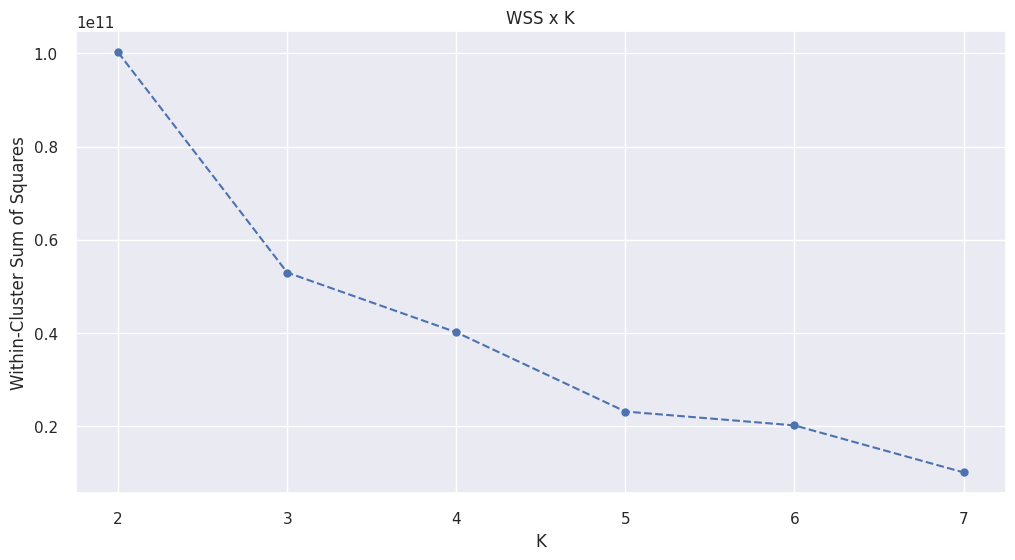

In [23]:
wss = []
for k in clusters:
    # model definition
    kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=CFG.seed)
    
    # model training
    kmeans.fit(X)
    
    # validation    
    wss.append(kmeans.inertia_)

# plot wss - Elbow Method - Método Cotovelo
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('WSS x K');

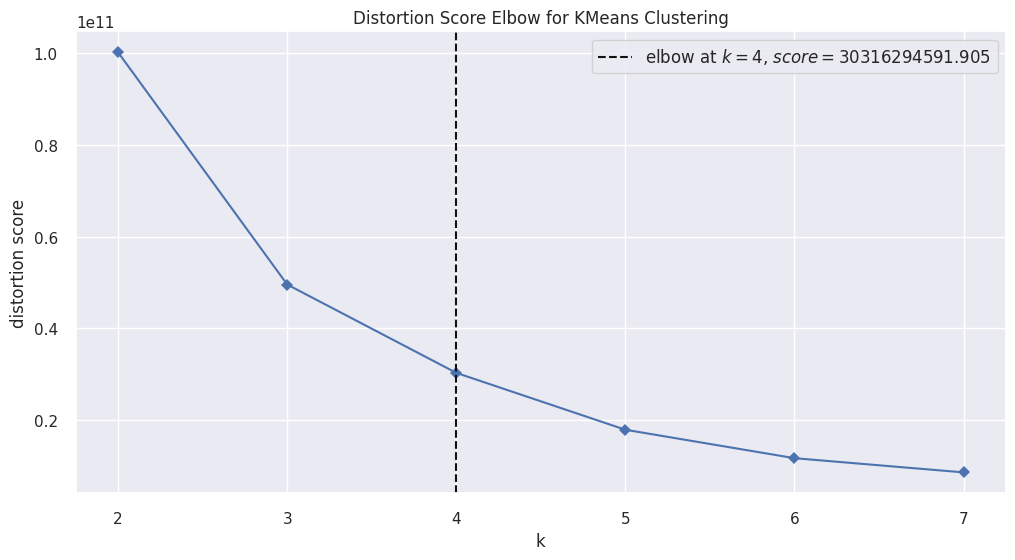

In [27]:
kmeans = KElbowVisualizer(KMeans(n_init=10), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2. Silhouette Score

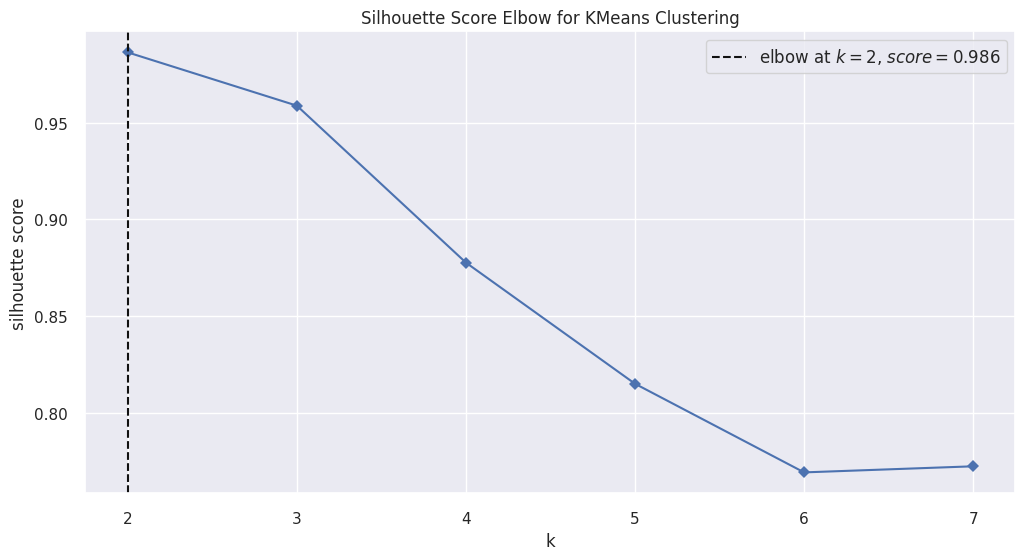

In [28]:
kmeans = KElbowVisualizer(KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit(X)
kmeans.show();

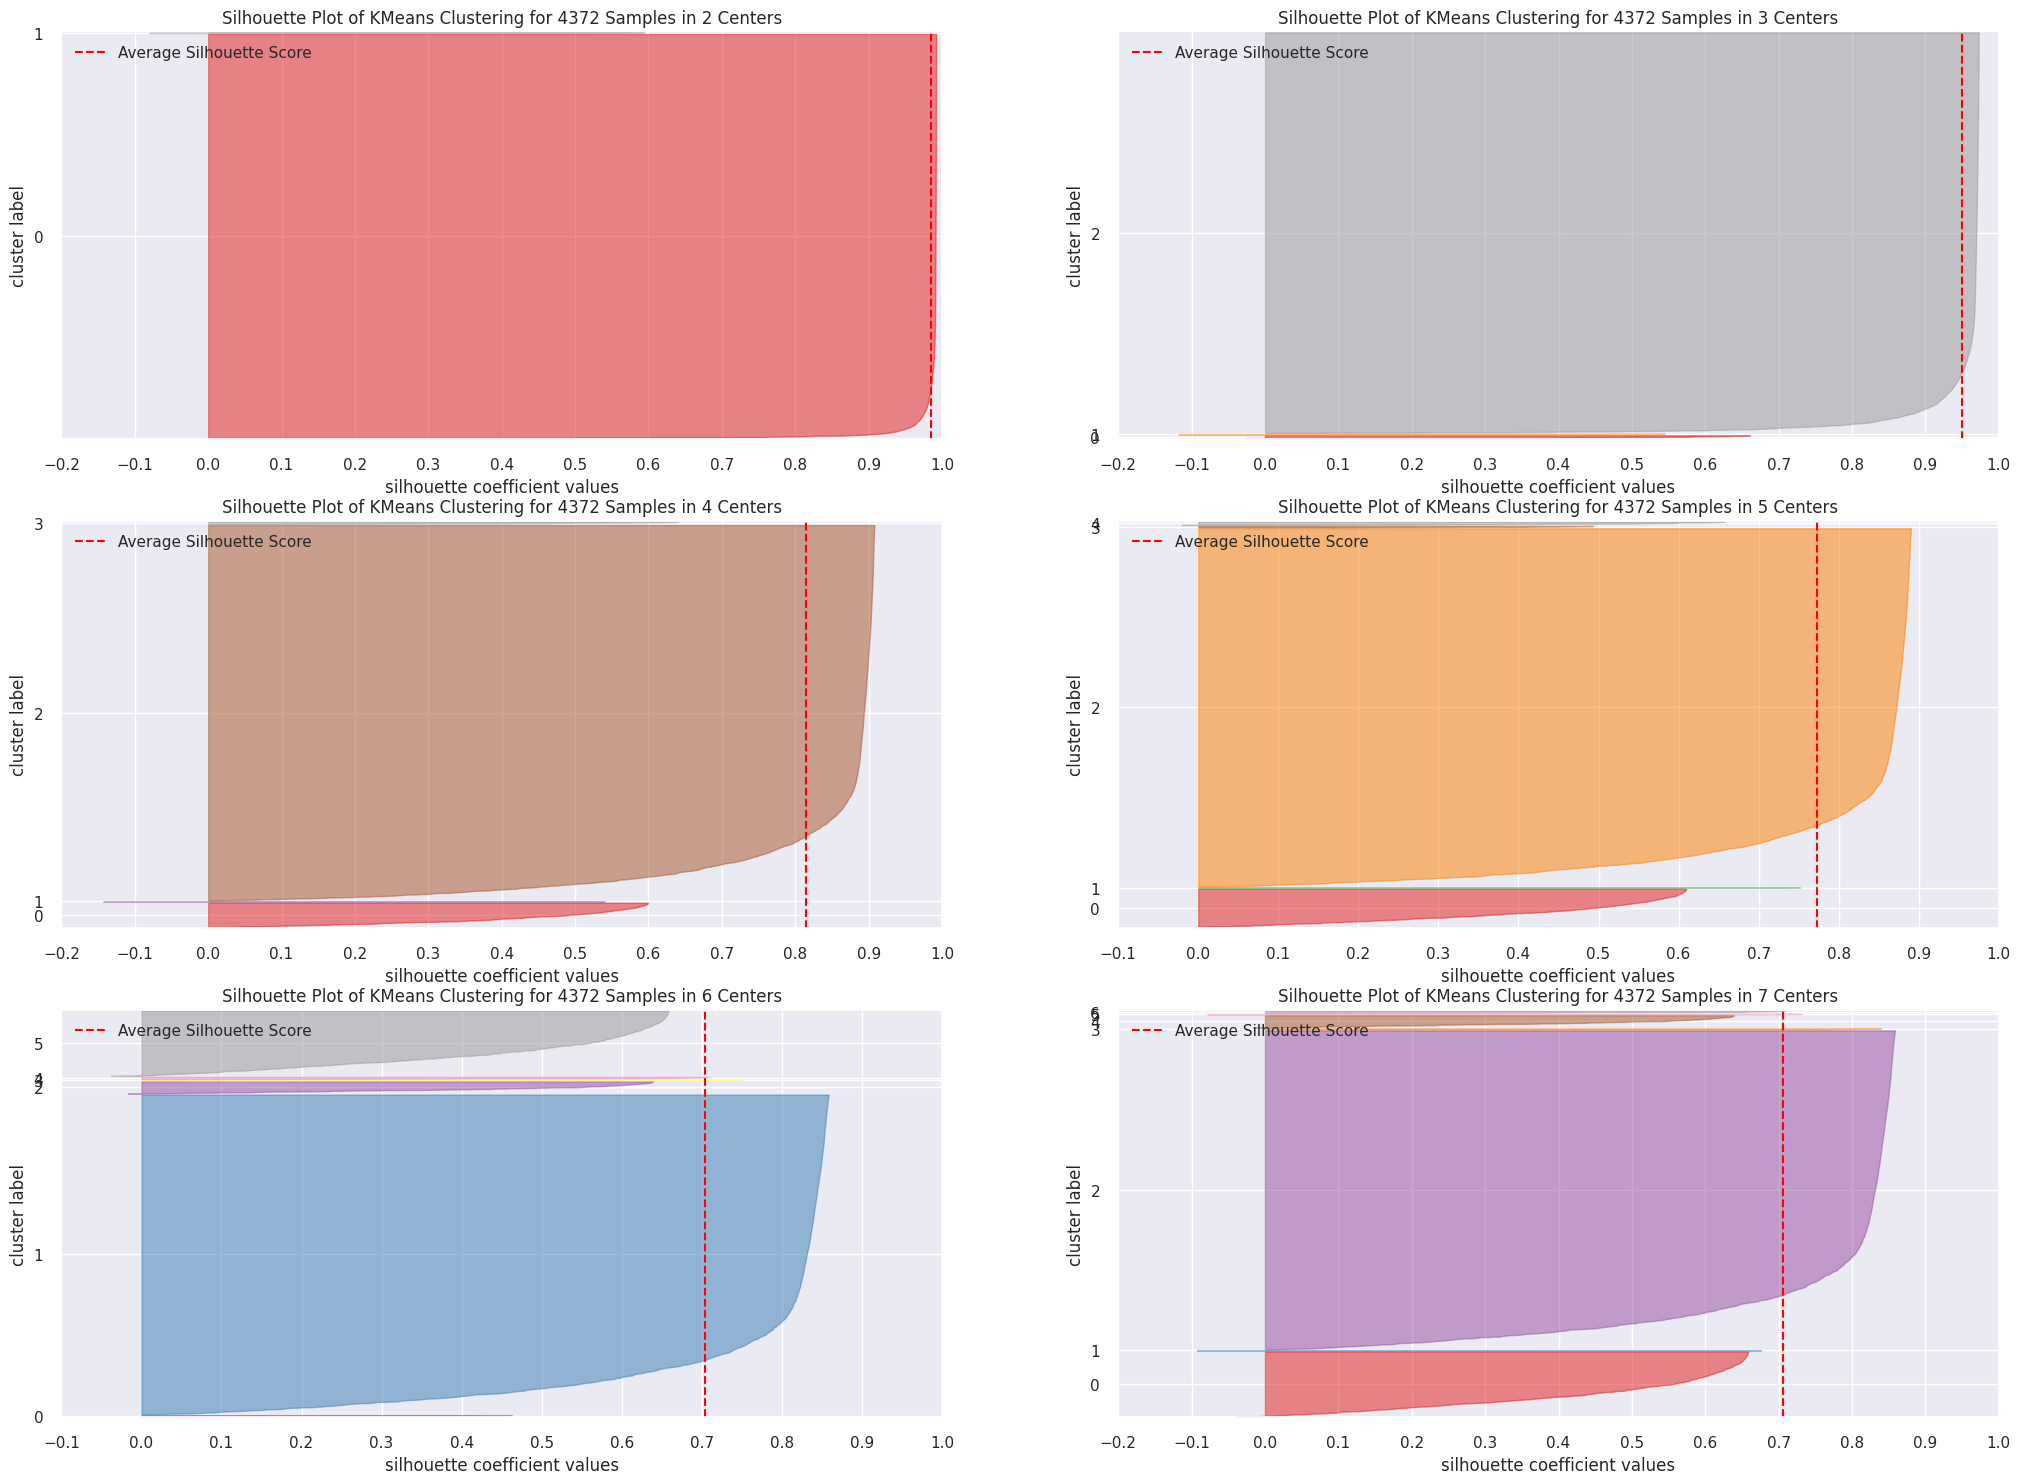

In [55]:
fig, ax = plt.subplots(3, 2, figsize=(25, 18))

for k in clusters:
    km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=CFG.seed)
    q, mod = divmod(k, 2)
    viz = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    viz.fit(X)
    viz.finalize()

# 8.0 Model Training

## 8.1. K-Means

In [23]:
# model definition
k = 4
kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.predict(X) # ou kmeans.labels_

## 8.2. Cluster Validation

In [24]:
## WSS 
print(f'WSS value:{kmeans.inertia_}')

## SS
print(f'SS value: {silhouette_score(X, labels, metric="euclidean")}')

WSS value:40056506734.60249
SS value: 0.8139972028952444


# 9.0 Cluster Analysis

In [25]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,monetary,recency,frequency,avg_ticket,cluster
0,17850,5288.63,302,35,16.95,3
1,13047,3079.10,31,18,15.71,0
2,12583,7187.34,2,18,28.63,3
3,13748,948.25,95,5,33.87,0
4,15100,635.10,330,6,105.85,0


## 9.1. Visualization Inspection

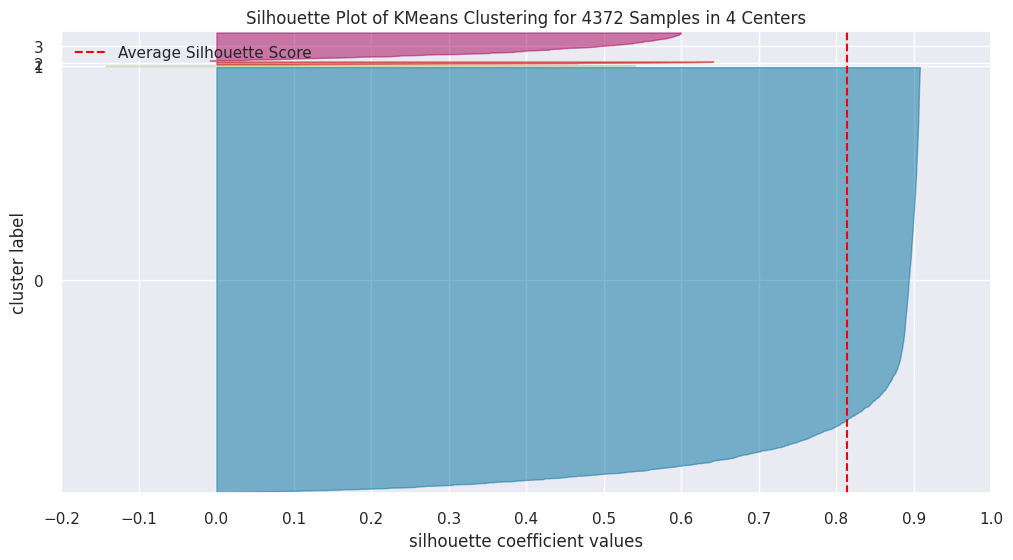

In [27]:
viz = SilhouetteVisualizer(kmeans, colors='yellowbrick')
viz.fit(X)
viz.finalize()

## 9.2. Two-Dimensional Plot

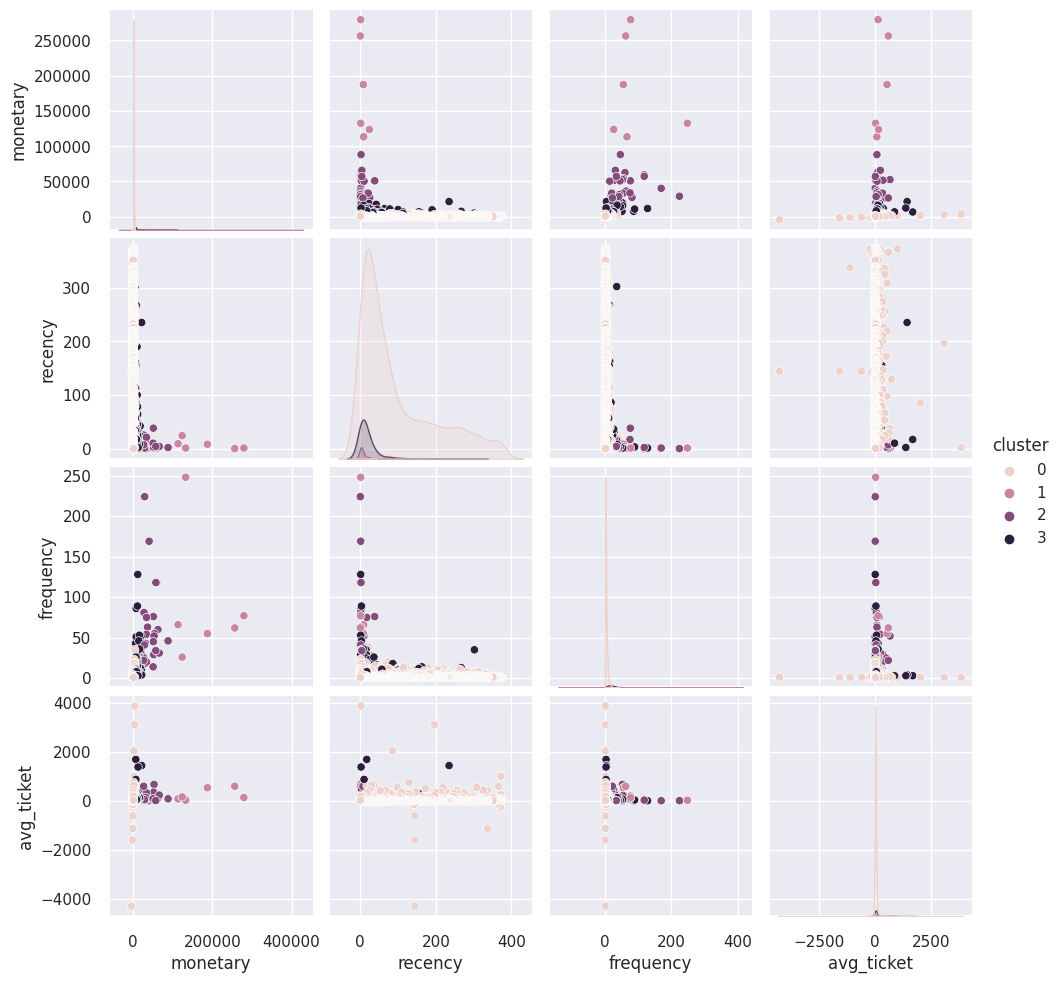

In [29]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster');

## 9.3. UMAP

In [30]:
X.head()

,monetary,recency,frequency,avg_ticket
0,5288.63,302,35,16.95
1,3079.10,31,18,15.71
2,7187.34,2,18,28.63
3,948.25,95,5,33.87
4,635.10,330,6,105.85


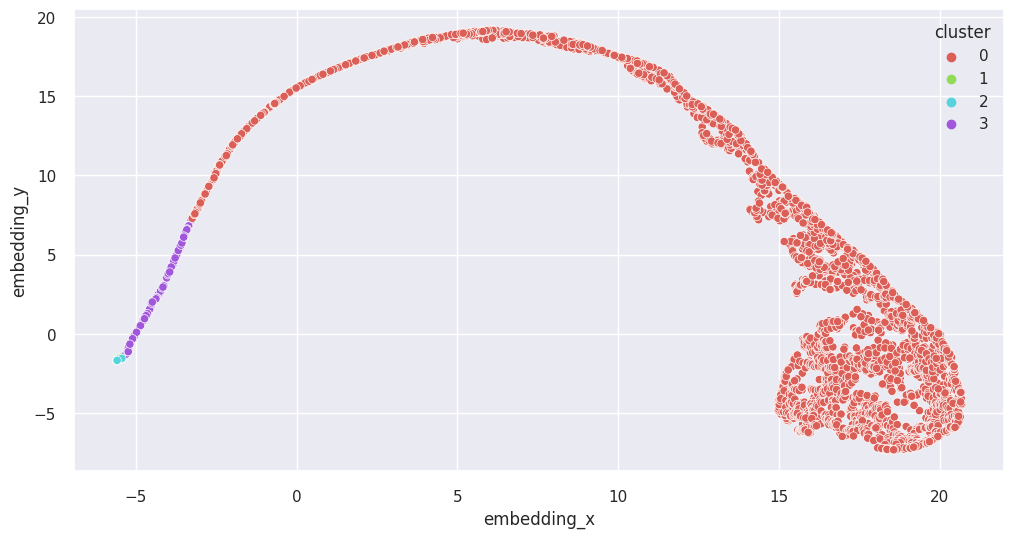

In [34]:
reducer = umap.UMAP(n_neighbors=70, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', 
                hue='cluster', 
                palette=sns.color_palette('hls', n_colors=df_viz['cluster'].nunique()),
               data=df_viz);

In [ ]:
## fig = px.scatter_3d(df9, x='recency', y='frequency', z='monetary', color='cluster')
# fig.show()

## 9.4. Cluster Profile

In [39]:
df9.head()

,customer_id,monetary,recency,frequency,cluster
0,17850,5288.63,302,35,0
1,13047,3079.10,31,18,0
2,12583,7187.34,2,18,0
3,13748,948.25,95,5,0
4,15100,635.10,330,6,0


In [35]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = (df_cluster['customer_id'] / df_cluster['customer_id'].sum())*100

# Avg Monetary
df_avg_monetary = df9[['monetary', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_monetary, on='cluster')

# Avg recency days
df_avg_recency = df9[['recency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, on='cluster')

# Avg frequency
df_avg_frequency = df9[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, on='cluster')

df_cluster

,cluster,customer_id,perc_customer,monetary,recency,frequency,avg_ticket
0,0,4071,93.12,946.70,96.97,3.64,25.36
1,1,6,0.14,182181.98,7.17,89.00,253.63
2,2,28,0.64,42614.39,6.18,57.82,162.86
3,3,267,6.11,8089.03,20.28,19.53,62.78


In [42]:
df9.shape

(4372, 5)

**Exemplo de leitura da tabela:**

- No cluster 1: composto por 6 pessoas, que gastaram 182.000 dólares em média, com uma recência média super baixa, pois compram a cada 7 dias (compram toda semana), comprando em média 90 produtos.

### Cluster 01:  (Premium - Candidato à Insider)
    - Número de customers: 6 (0,14% dos clientes)
    - Recência média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: U$ 182.182,00 
    
### Cluster 02: (VIPs)
    - Número de customers: 31 (0,71% dos clientes)
    - Recência média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: U$ 40.543,52 
    
### Cluster 03: (Ocasionais)
    - Número de customers: 4.335 (99% dos clientes)
    - Recência média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: U$ 1.372,57 


# 10.0 Deployment

# 11.0 SandBox

## 11.1. Original Dataset

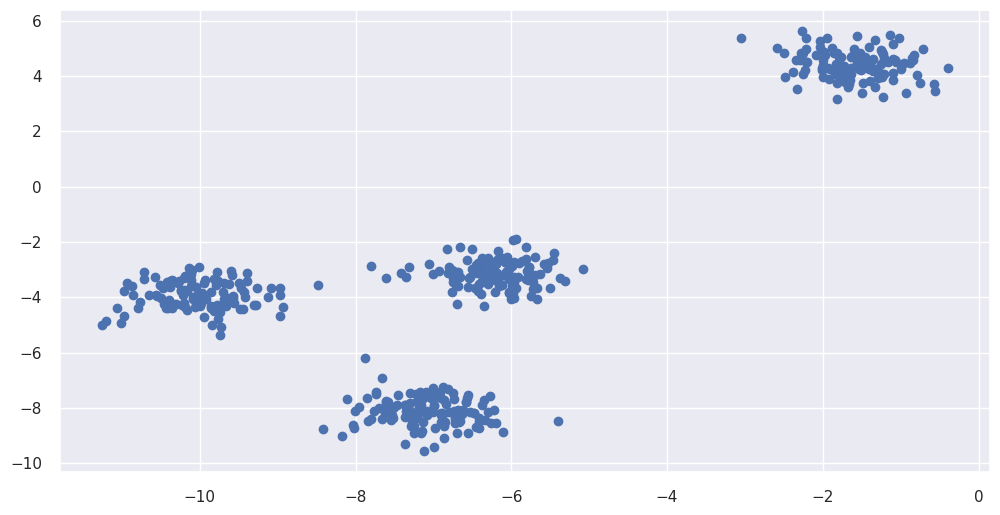

In [49]:
from sklearn.datasets import make_blobs #cria pontos no espaço

X, y = make_blobs(n_samples=500, n_features=2, 
                  centers=4,
                  cluster_std=0.5,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=CFG.seed)
# plot dataset
plt.scatter(X[:, 0], X[:, 1])

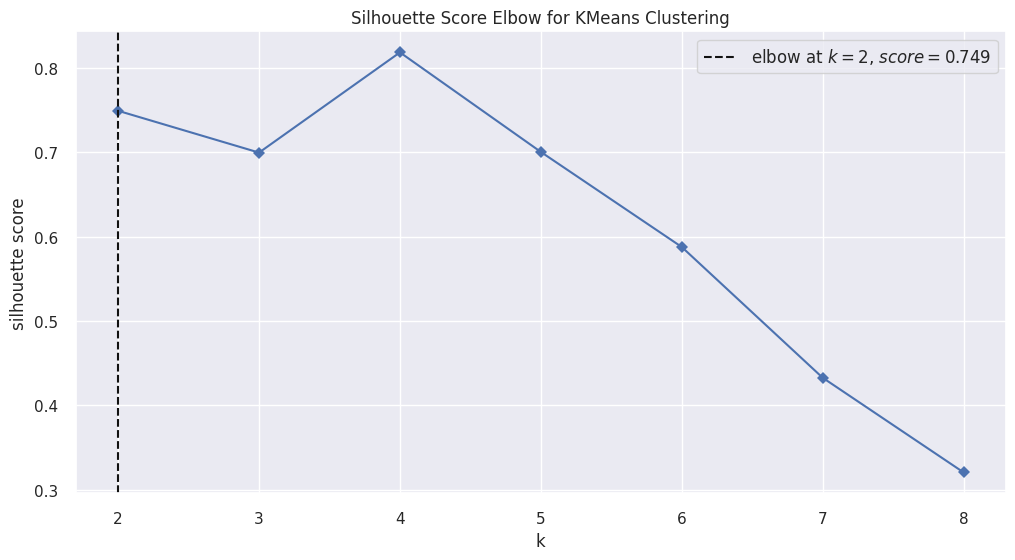

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [50]:
# modeling
clusters = list(range(2, 9))
kmeans = KElbowVisualizer(KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show()

## 11.2. Silhouette Analysis

IndexError: index 2 is out of bounds for axis 0 with size 2

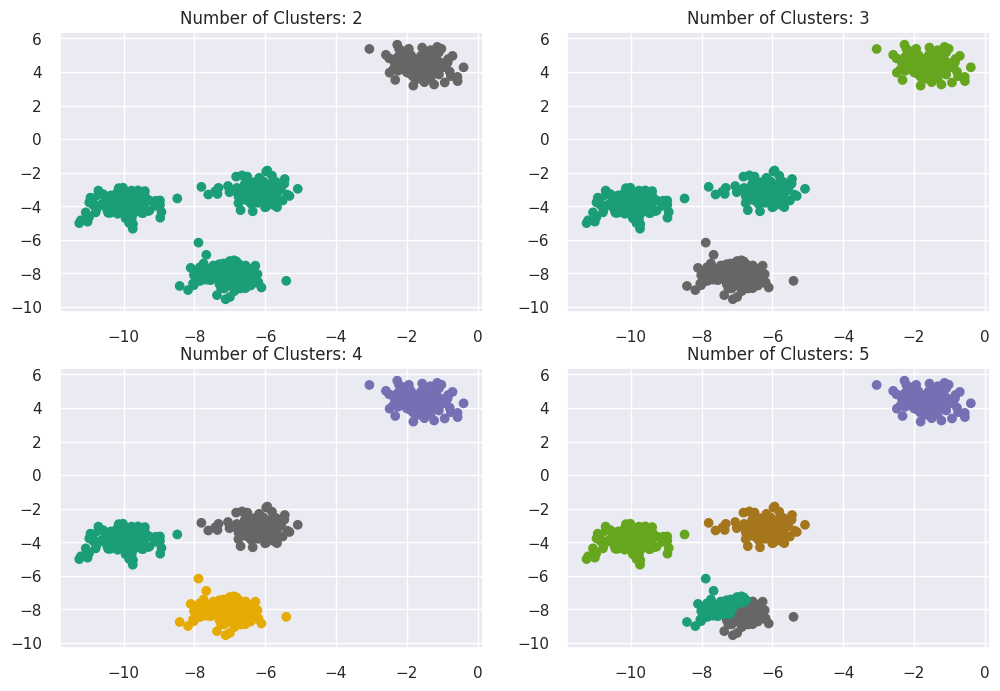

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
for i in clusters:
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=CFG.seed)
    kmeans.fit(X)
    
    q, mod = divmod(i, 2)
    ax[q-1, mod].scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap=plt.cm.Dark2)
    ax[q-1, mod].set_title('Number of Clusters: {}'.format(i))
plt.show()

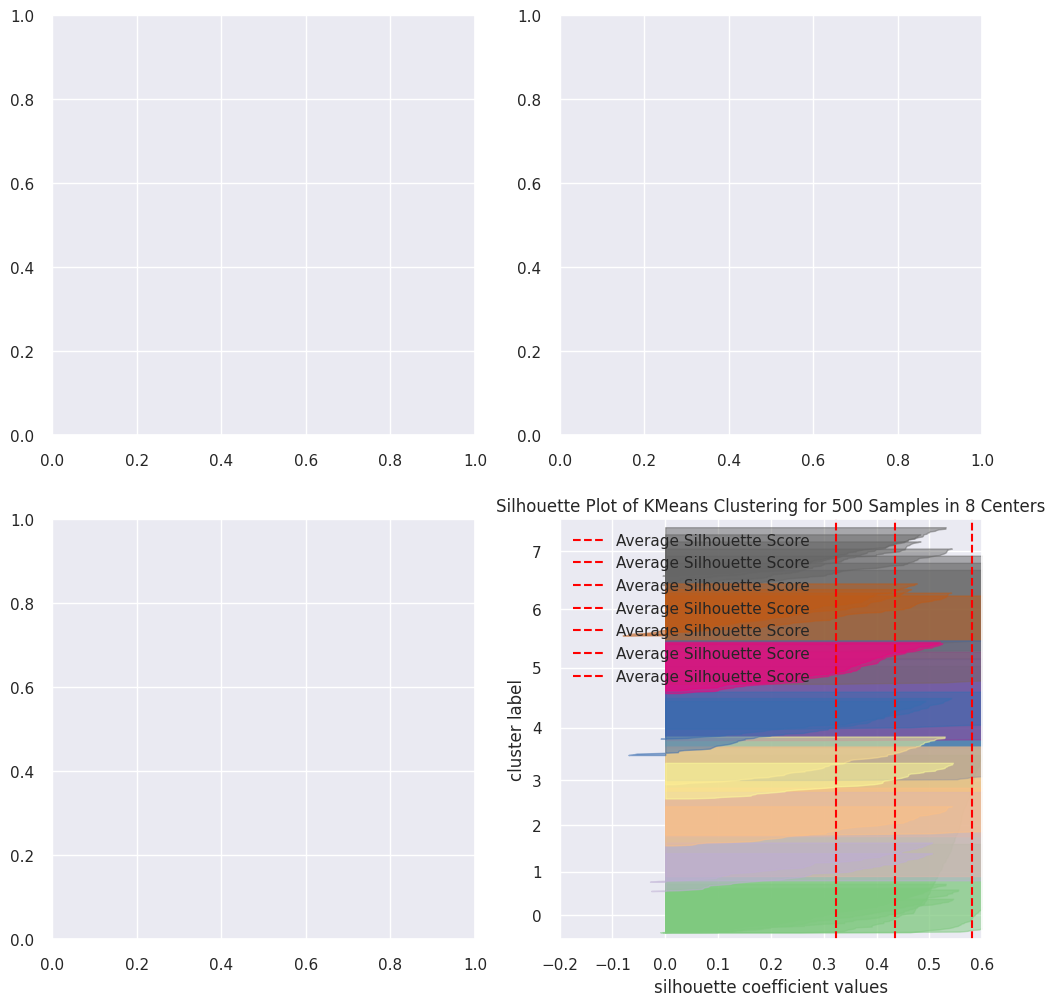

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
for i in clusters:
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=CFG.seed)
    q, mod = divmod(i, 2)
    
    visualizer = SilhouetteVisualizer(kmeans, colors='Accent')
    visualizer.fit(X)
    visualizer.finalize()